In [1]:
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import powerlaw

import arrow

from scipy.special import factorial
from math import e

### Store base data as a dataframe

In [2]:
def create_base_data(project):
    PATH_TO_DATA = './data/2021-IEEE-Blockchain/data/20210715_' + project + '.csv'  # Change if needed
    column_names = ["row", "tx_hash", "token_address", "from_address", "to_address", "from_is_contract", "to_is_contract", "token_id", "blk_number", "blk_timestamp", "eth_value", "weth_value"]
    
    df = pd.read_csv(PATH_TO_DATA, delimiter=',', skiprows=1, names=column_names)
    
    df["from_address"] = df.from_address.apply(lambda x: x.strip())
    df["to_address"] = df.to_address.apply(lambda x: x.strip())
    
    return df

In [3]:
projects = ['bayc']
dataframes = {}

for project in projects:
    dataframes[project] = create_base_data(project)

### Build time-based dataframes

In [4]:
def create_timed_data(df):
    ZERO_ADDRESS = '0x0000000000000000000000000000000000000000'
    column_names = ["date", "days_since_mint", "from_address", "to_address", "token_id", "blk_number", "eth_value", "weth_value"]
    
    df = dataframes[project]
    df_time = pd.DataFrame(columns=column_names)
    
    for index, row in df.iterrows():
        blk_timestamp = row['blk_timestamp']
        date = arrow.get(blk_timestamp).datetime

        # Remove whitespace from address rows
        from_address = row['from_address']
        to_address = row['to_address']
        token_id = row['token_id']
        blk_number = row['blk_number']
        eth_value = row['eth_value']
        weth_value = row['weth_value']
        
        # Get days since mint and place a dummy value that we reference below
        if from_address == ZERO_ADDRESS:
            days_since_mint = 0
        else:
            days_since_mint = 1
            
        df_time = df_time.append({
            'date': date,
            'days_since_mint': days_since_mint,
            'from_address': from_address,
            'to_address': to_address,
            'token_id': token_id, 
            'blk_number': blk_number,
            'eth_value': eth_value,
            'weth_value': weth_value
        }, ignore_index=True)
        
    # Replace the dummy value by looking at the original mint date in the original dataframe
    for index, row in df_time.iterrows():
        days_since_mint = row['days_since_mint']
        
        if days_since_mint == 1:
            from_address = row['from_address']
            date_now = row['date']
            
            df_index = df.index[df['to_address'] == from_address]
            date_mint = min(df_time.loc[df_index, 'date'])

            date_diff = date_now - date_mint
            date_diff = date_diff.days
            
            df_time.at[df_index,'days_since_mint'] = date_diff
            
    df_time['days_since_mint'] = df_time['days_since_mint'].fillna(0)
    return df_time

In [5]:
dataframes_time = {}

for project, df in dataframes.items():
    dataframes_time[project] = create_timed_data(df)

### Build graph objects from time base dataframes

In [6]:
def build_graph_from_timed(df_time):    
    # Building a network per block
    # we will use a weighted and directed graph.
    graph = nx.DiGraph()

    plot_interval = 24 * 3600 * 10 # 1 day
    start_timestamp = df_time['date'].iloc[0]

    # loop over the pandas dataframe.
    for index, row in df_time.iterrows():

        # read the values from the dataframe.
        # token_id  blk_timestamp eth_value weth_value
        date = row['date']
        from_address = row['from_address']
        to_address = row['to_address']
        token_id = row['token_id']
        blk_number = row['blk_number']
        eth_value = row['eth_value']
        weth_value = row['weth_value']

        # make sure both addresses are in the graph.
        if from_address not in graph:
            graph.add_node(from_address)
        if to_address not in graph:
            graph.add_node(to_address)

        # lookup value of both nodes at the time of this block
        # if (not from_address == '0x0000000000000000000000000000000000000000'):
        #     address = w3.toChecksumAddress(from_address)
        #     value_from = w3.eth.get_balance(address, block_identifier=block)
        # if (not to_address == '0x0000000000000000000000000000000000000000'):
        #     address = w3.toChecksumAddress(to_address)
        #     value_to = w3.eth.get_balance(address, block_identifier=block)

        # set the attributes on this node.
        # TODO: replace dummy values
        nx.set_node_attributes(graph, {from_address:100, to_address:100}, 'value')

        # keep track of how many trades a wallet has done.
        trades = nx.get_node_attributes(graph, "trades")
        if from_address in trades:
            nx.set_node_attributes(graph, {from_address:trades[from_address] + 1}, 'trades')
        else:
            nx.set_node_attributes(graph, {from_address:1}, 'trades')
        if to_address in trades:
            nx.set_node_attributes(graph, {to_address:trades[to_address] + 1}, 'trades')
        else:
            nx.set_node_attributes(graph, {to_address:1}, 'trades')

        # check if this NFT has already been sold and if yes, remove the old sale.
        # this might be a candidate for memoization - c.b.
        remove_edges = []
        for (u,v,d) in graph.edges.data():
            if d['token_id'] == token_id:
                remove_edges.append((u,v))
            # we need to remove them in a seperate step, since otherwise we change the datastructure that we are iterating over.
        for (u,v) in remove_edges:
            graph.remove_edge(u,v)

        # add an edge for the transaction.
        # TODO this will be changed
        value = eth_value + weth_value # currently we do not care if it was eth or weth
        graph.add_edge(from_address, to_address, weight=value, token_id=token_id) # keep track of token id by adding it to the edge.
        
    return graph

def build_graph_attributes(graph, project):
    return {
        "project": project,
        "graph": graph,
        "number_of_nodes": graph.number_of_nodes(),
        "avg_clustering": nx.average_clustering(graph),
        "reciprocity": nx.reciprocity(graph),
        "assortativity": nx.degree_assortativity_coefficient(graph),
        "assortativity_base": nx.degree_pearson_correlation_coefficient(graph.to_undirected(), weight='weight'),
        "assortativity_out_out": nx.degree_pearson_correlation_coefficient(graph, x='out', y='out', weight='weight'),
        "assortativity_in_in": nx.degree_pearson_correlation_coefficient(graph, x='in', y='in', weight='weight'),
        "assortativity_in_out": nx.degree_pearson_correlation_coefficient(graph, x='in', y='out', weight='weight'),
        "centrality_degree": nx.degree_centrality(graph),
        "centrality_closeness": nx.closeness_centrality(graph),
        "centrality_betweenness": nx.betweenness_centrality(graph),
        "centrality_eigenvector": nx.eigenvector_centrality(graph)   
    }

In [7]:
graphs = {}

for project, df_time in dataframes_time.items():
    graphs[project] = build_graph_attributes(build_graph_from_timed(df_time), project)

### Plot ETH value over time

In [8]:
def plot_eth_over_time(df_time):

    # eth_value over time
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Date vs. eth_value', fontsize=20, y=1.1, ha="center")
    plt.xlabel("date")
    plt.ylabel("eth_value")
    plt.plot(df_time.date, df_time.eth_value, label='Base')
    plt.legend(bbox_to_anchor=(1.05, 1))

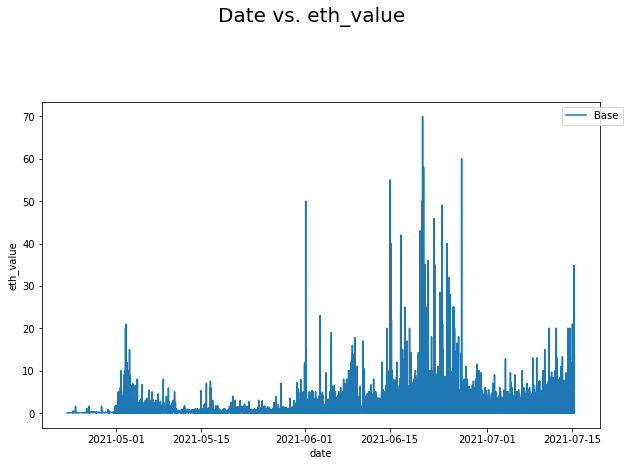

In [9]:
for project, df_time in dataframes_time.items():
    plot_eth_over_time(df_time)

### Plot ETH value over days since mint

In [10]:
def plot_eth_over_dsm(df_time):
    sort = lambda x: x.sort_values(by=['days_since_mint'])
    group = lambda x: x.groupby(by=['days_since_mint']).sum()

    df_time_sorted = group(sort(df_time))
    
    # eth_value over days since mint
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Date since mint vs. eth_value', fontsize=20, y=1.1, ha="center")
    plt.xlabel("days_since_mint")
    plt.ylabel("eth_value")
    plt.plot(df_time_sorted.index, df_time_sorted.eth_value, label='Base')
    plt.legend(bbox_to_anchor=(1.05, 1))

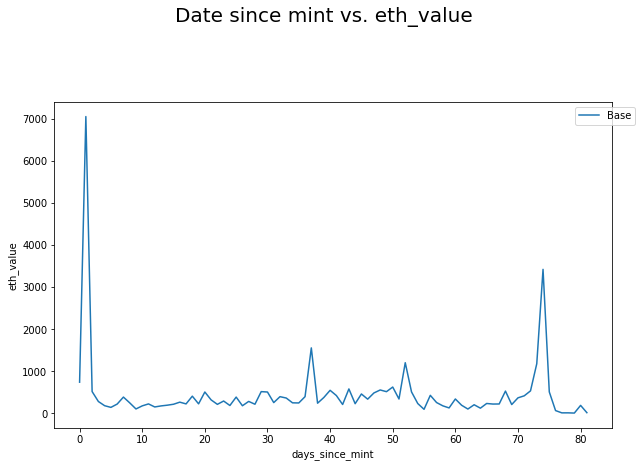

In [11]:
for project, df_time in dataframes_time.items():
    plot_eth_over_dsm(df_time)

### Plot number of transactions over time

In [12]:
def plot_transactions_over_time(df_time):
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Number of transactions over time', fontsize=20, y=1.1, ha="center")
    plt.hist(df_time.date)
    plt.show()

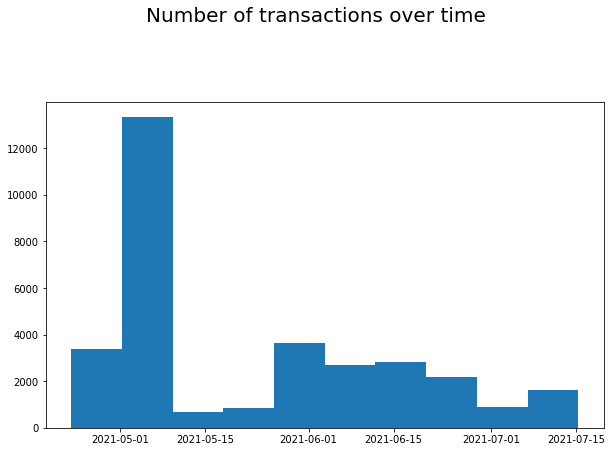

In [13]:
for project, df_time in dataframes_time.items():
    plot_transactions_over_time(df_time)

### Plot centrality measures

In [14]:
def scatter_network_centrality(graph, centrality_measure_1, centrality_measure_2):
    labels = {
        "centrality_degree": "Degree Centrality",
        "centrality_closeness": "Closeness Centrality",
        "centrality_betweenness": "Betweenness Centrality",
        "centrality_eigenvector": "Eigenvector Centrality"
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_label = labels[centrality_measure_1]
    y_label = labels[centrality_measure_2]
    
    x_series = list(graph[centrality_measure_1].values())
    y_series = list(graph[centrality_measure_2].values())

    fig.suptitle(f'{graph["project"]} - {x_label} vs. {y_label}', fontsize=20, y=1.1, ha="center")
    plt.scatter(x_series, y_series)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

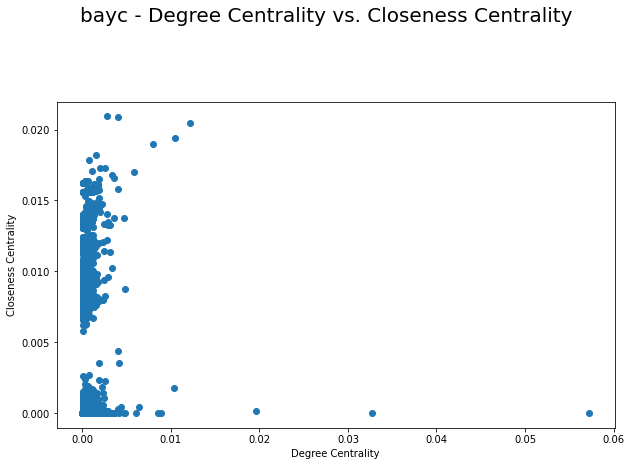

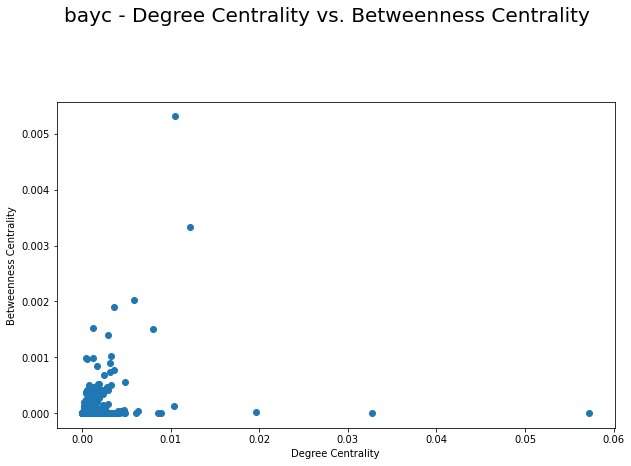

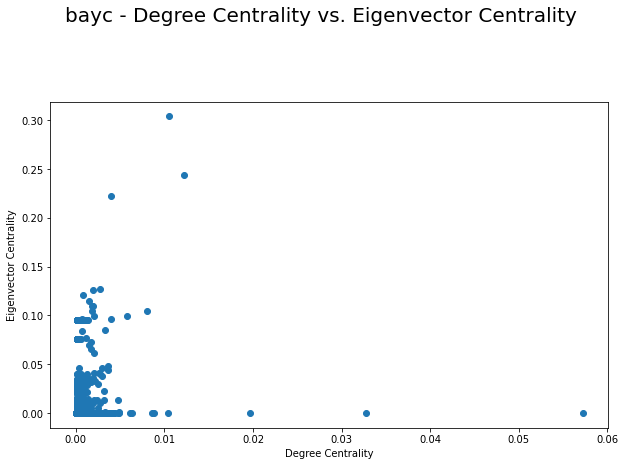

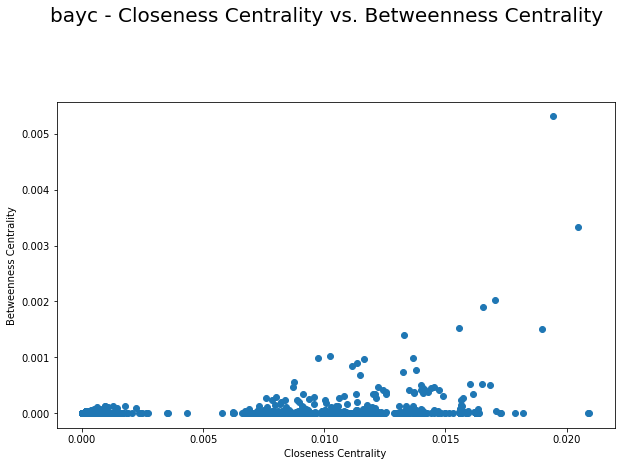

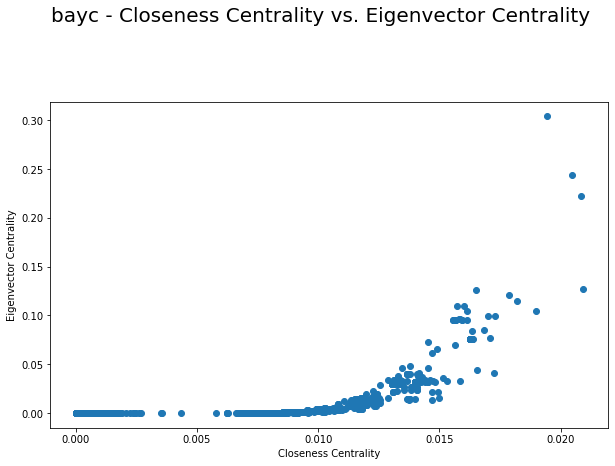

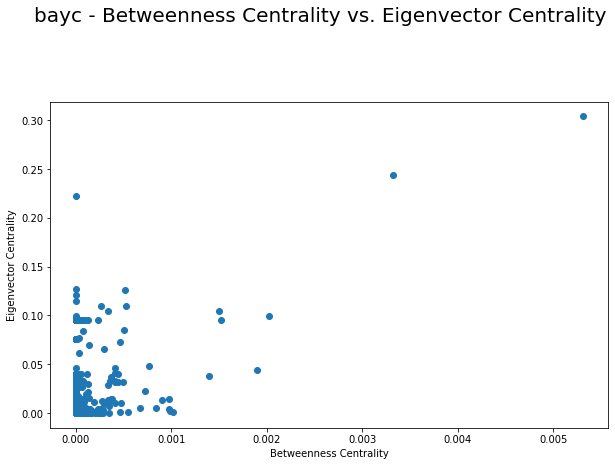

In [15]:
centralities = ['centrality_degree', 'centrality_closeness', 'centrality_betweenness', 'centrality_eigenvector']

centrality_pairs = [
    ('centrality_degree', 'centrality_closeness'),
    ('centrality_degree', 'centrality_betweenness'),
    ('centrality_degree', 'centrality_eigenvector'),
    ('centrality_closeness', 'centrality_betweenness'),
    ('centrality_closeness', 'centrality_eigenvector'),
    ('centrality_betweenness', 'centrality_eigenvector'),
]

for project, graph in graphs.items():
    for pair in centrality_pairs:
        scatter_network_centrality(graph, pair[0], pair[1])

### Build snapshot graphs at different time periods

In [16]:
def build_graph_snapshots(df_time, project):
    """Simpler version of below function which just returns the graph objects"""
    res = {}
    
    df_time['date_quantile'], bins = pd.qcut(df_time['date'], 10, labels=False, retbins=True)
    time_buckets = np.unique(df_time["date_quantile"].to_numpy())
    
    for time_bucket, label in zip(time_buckets, bins):
        selection = df_time[(df_time['date_quantile'] == time_bucket)]
        graph_snapshot = build_graph_from_timed(selection)
        graph_snapshot_random = nx.algorithms.smallworld.random_reference(graph_snapshot.to_undirected(), niter=10, connectivity=False)
        
        res[label] = (graph_snapshot, graph_snapshot_random)
        
    return res


def build_df_snapshots(df_time, project):
    column_names = [
        "time_bucket", 
        "time_bucket_label",
        "number_of_nodes", 
        "avg_clustering", 
        "reciprocity", 
        "assortativity", 
        "assortativity_base", 
        "assortativity_out_out", 
        "assortativity_in_in", 
        "assortativity_in_out",
        "centrality_degree",
        "centrality_closeness", 
        "centrality_betweenness",
        "centrality_eigenvector",
        "avg_clustering_random",
        "assortativity_random"
    ]
    
    df_snapshots = pd.DataFrame(columns=column_names)
    
    df_time['date_quantile'], bins = pd.qcut(df_time['date'], 10, labels=False, retbins=True)
    time_buckets = np.unique(df_time["date_quantile"].to_numpy())
    
    for time_bucket, label in zip(time_buckets, bins):
        selection = df_time[(df_time['date_quantile'] == time_bucket)]
        graph_snapshot = build_graph_from_timed(selection)
        graph_snapshot_random = nx.algorithms.smallworld.random_reference(graph_snapshot.to_undirected(), niter=10, connectivity=False)
        
        df_snapshots = df_snapshots.append({
            "time_bucket": time_bucket,
            "time_bucket_label": label,
            "number_of_nodes": graph_snapshot.number_of_nodes(),
            "avg_clustering": nx.average_clustering(graph_snapshot),
            "reciprocity": nx.reciprocity(graph_snapshot),
            "assortativity": nx.degree_assortativity_coefficient(graph_snapshot),
            "assortativity_base": nx.degree_pearson_correlation_coefficient(graph_snapshot.to_undirected(), weight='weight'),
            "assortativity_out_out": nx.degree_pearson_correlation_coefficient(graph_snapshot, x='out', y='out', weight='weight'),
            "assortativity_in_in": nx.degree_pearson_correlation_coefficient(graph_snapshot, x='in', y='in', weight='weight'),
            "assortativity_in_out": nx.degree_pearson_correlation_coefficient(graph_snapshot, x='in', y='out', weight='weight'),
            "centrality_degree": nx.degree_centrality(graph_snapshot),
            "centrality_closeness": nx.closeness_centrality(graph_snapshot),
            "centrality_betweenness": nx.betweenness_centrality(graph_snapshot),
            "avg_clustering_random": nx.average_clustering(graph_snapshot_random),
            "assortativity_random": nx.degree_assortativity_coefficient(graph_snapshot_random)
            # "centrality_eigenvector": nx.eigenvector_centrality(graph_snapshot) # was causing problems
        }, ignore_index=True)
        
    return df_snapshots.sort_values(by=['time_bucket'])

In [17]:
dataframes_snapshots = {}
graph_snapshots = {}

for project, df_time in dataframes_time.items():
    dataframes_snapshots[project] = build_df_snapshots(df_time, project)
    graph_snapshots[project] = build_graph_snapshots(df_time, project)

### Plot snapshot characteristics

In [18]:
# This code is just a quick demo and might need to be changed when multiple projects are run
# Because the plots write over one another
def plot_snapshot_attributes_over_time(df_snapshots, y_list, y_colors):
    df_snapshots = df_snapshots.sort_values(by=['time_bucket_label'])
    
    fig = plt.figure(1, figsize=(10, 6), dpi=60)   
    fig.suptitle('Network Characteristics over Time', fontsize=20, y=1, ha="center")

    plt.xlabel("Time Period")
    plt.ylabel("Attribute")
    
    for i, y in enumerate(y_list):
        plt.plot(df_snapshots['time_bucket'], df_snapshots[y], label=y, color=y_colors[i])
        
    plt.legend(bbox_to_anchor=(1.05, 1))

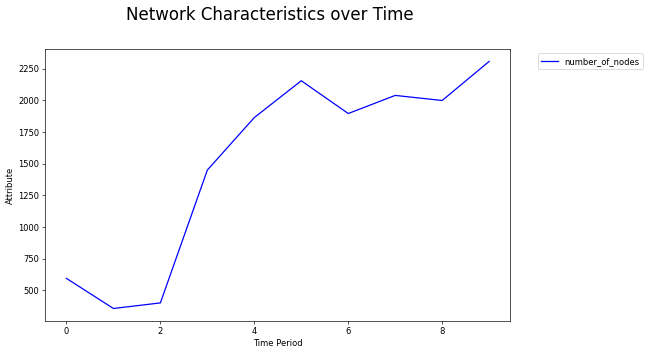

In [19]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_time(df_snapshots, ['number_of_nodes'], ['b'])

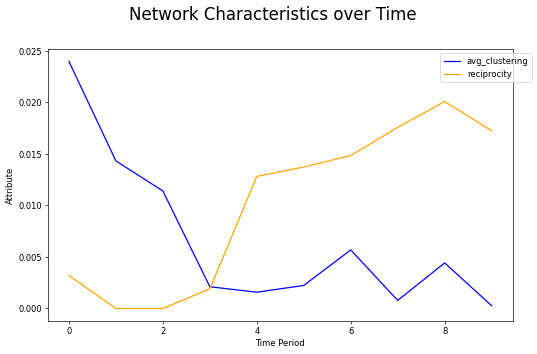

In [20]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_time(df_snapshots, ['avg_clustering', 'reciprocity'], ['b', 'orange'])

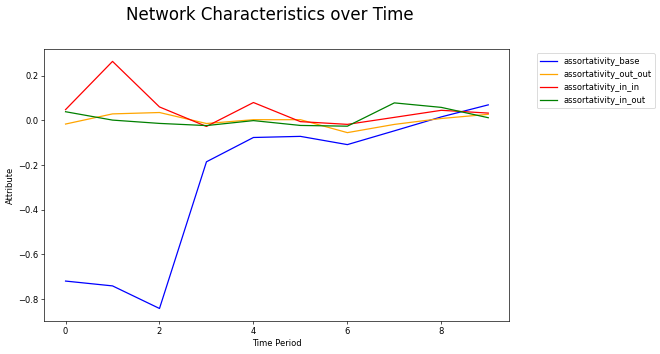

In [21]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_time(df_snapshots, ['assortativity_base', 'assortativity_out_out', "assortativity_in_in", "assortativity_in_out"], ['b', 'orange', 'red', 'green'])

In [22]:
def plot_snapshot_attributes_over_nodes(df_snapshots, y_list, y_colors):
    df_snapshots = df_snapshots.sort_values(by=['number_of_nodes'])
    
    fig = plt.figure(1, figsize=(10, 6), dpi=60)   
    fig.suptitle('Network Characteristics over Time', fontsize=20, y=1, ha="center")

    plt.xlabel("Number of Nodes")
    plt.ylabel("Attribute")
    
    for i, y in enumerate(y_list):
        plt.plot(df_snapshots['number_of_nodes'], df_snapshots[y], label=y, color=y_colors[i])
        
    plt.legend(bbox_to_anchor=(1.05, 1))

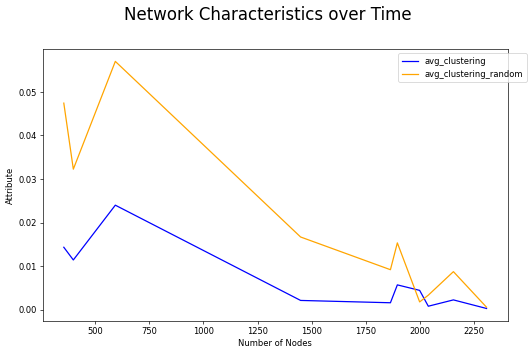

In [23]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_nodes(df_snapshots, ['avg_clustering', 'avg_clustering_random'], ['b', 'orange'])

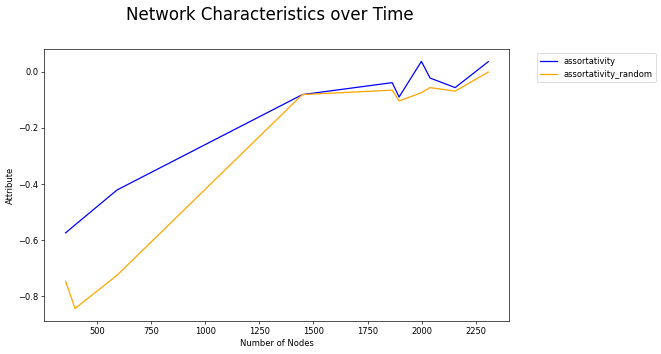

In [24]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_nodes(df_snapshots, ['assortativity', 'assortativity_random'], ['b', 'orange'])

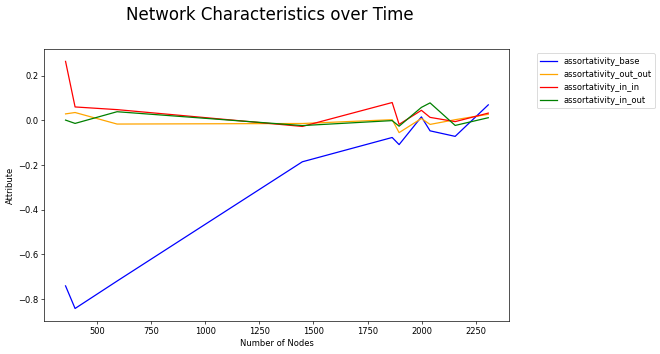

In [25]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_nodes(df_snapshots, ['assortativity_base', 'assortativity_out_out', "assortativity_in_in", "assortativity_in_out"], ['b', 'orange', 'red', 'green'])

### Power law analysis

In [26]:
def pure(x, alpha):
    return x**(-alpha)

def poisson(k, avg_degree):
    return (np.exp(-1 * avg_degree) * np.power(avg_degree, k)) / factorial(k)

def exp(k, avg_degree):
    return ((1/avg_degree) * np.exp((k * (-1)) / avg_degree))

def round_float(x):
    if x in [float("-inf"),float("inf")]: return float(0)
    return x

In [27]:
def plot_graph_power_law(g,project):
    k = np.asarray([d for d in dict(g.degree()).values()])
    avg_degree = sum(k) / len(g.nodes())

    spacing = np.linspace(min(k),max(k),len(k))
    
    fit = powerlaw.Fit(k)
    
    alpha = fit.power_law.alpha
    sigma = fit.power_law.sigma
    
    # This guy is causing problems unfortunately 
    # fit.power_law.plot_pdf(color='b', linestyle='--', label="Fit PDF")
    
    plt.plot(spacing, pure(spacing, alpha), color='r', label='Pure alpha Fit')
    plt.plot(spacing, poisson(spacing, avg_degree), color='g', label="Poisson Dist.")
    plt.plot(spacing, exp(spacing, avg_degree), color='orange', label="Exponential Dist.")
    
    plt.legend()
    plt.title(project)
    
    plt.xlabel("k")
    plt.ylabel("p(k)")

    plt.annotate("alpha: {:.2f}\nsigma: {:.2f}".format(alpha, sigma), xy=(0.80, 0.85), xycoords='axes fraction')
    
    plt.ylim(0.000000001, 1)

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
/var/folders/gk/khvnn6wj7dlftf3q15wdh9hw0000gn/T/ipykernel_40616/637017620.py:2: RuntimeWarning: divide by zero encountered in power
  return x**(-alpha)


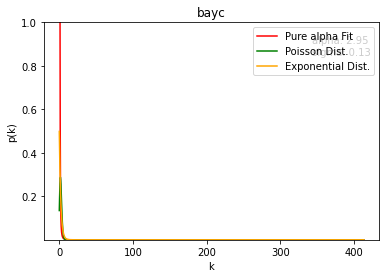

In [28]:
for project, graph in graphs.items():
    plot_graph_power_law(graph['graph'], project)